In [1]:
select_features=False

In [2]:
run load-clean-select.ipynb

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Morphology was measured for 1029.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 1029 cells.

The are no duplicated column names: True
Reading the dataset with E-cadherin...
E-cadherin was measured for 546 cells.

The are no duplicated column names: True
Reading the dataset with Vimentin and Cytokeratins...
Vimentin and Cytokeratins were measured for 483 cells.

The are no duplicated column names: True

Full dataset has shape: (1029, 562)
Initial shape is: (1029, 562)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centerZ_nucl',
       'loc_maxintensityZ_dap

###### Undersample images

In [ ]:
# np.random.seed(42)
image_id = np.random.choice(measurements_red[measurements_red.stiffness == '2.0'].image.unique(), 20)
print(image_id)
measurements_red[measurements_red.image.isin(image_id)].shape

In [ ]:
measurements_b = measurements_red.drop(measurements_red[measurements_red.image.isin(image_id)
                                                         ].index
                                        ).reset_index(drop=True)
measurements_b.shape

# Which dataset?

In [3]:
# The full dataset
# df = measurements
# Dataset without clusters at 64kPa
df = measurements_red
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa
# df = measurements_5
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa with balanced classes
# df = measurements_b
df.shape

(826, 499)

## Scale and save

In [ ]:
# Features to use
cols = geom_cols
# Feature map
X = df[cols]

# Standartise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame(data = X_scaled, columns = geom_cols).to_csv("../datasets/BandC_morphology.csv")

## Separate dataframes for combinations

In [ ]:
dfB = df[df.combination == "B"].reset_index(drop=True)
dfC = df[df.combination == "C"].reset_index(drop=True)
print(dfB.shape, dfC.shape)

# Some functions

In [4]:
# Prepare a vector of colours mapped to the 'stiffness' column
def create_palette(df, by='stiffness', show=False):
    if by == 'stiffness':
        n_levels = df.stiffness.unique().size
        palette = dict(zip(df.stiffness.unique(), sns.color_palette("Set3", n_levels)))
        row_colors = df.stiffness.map(palette)
    elif by == 'cluster':
        n_levels = df.cluster.unique().size
        if n_levels == 2:
            palette = {0 : sns.color_palette("PRGn", 20)[15], 1 : sns.color_palette("PRGn", 20)[4]}
#             palette = dict(zip(df.cluster.unique(), sns.xkcd_palette(["powder blue", "pale orange"])))
        else:
            palette = dict(zip(range(n_levels), sns.color_palette("Set2", n_levels)))
        row_colors = df.cluster.map(palette)
    elif by == 'biom':
        palette = {df.biom.unique()[0] : sns.color_palette("RdBu", 10)[1],
                   df.biom.unique()[1] : sns.color_palette("RdBu", 10)[8]}
        row_colors = df.biom.map(palette)
    elif by == 'comb':
        palette = {df.combination.unique()[0] : sns.color_palette("RdBu", 10)[1],
                   df.combination.unique()[1] : sns.color_palette("RdBu", 10)[8]}
        row_colors = df.combination.map(palette)
        
    if show:
#         print(list(palette.keys()))
        sns.palplot(palette.values());
    
    return row_colors, palette
# plt.savefig('../results/My palette.png', bbox_inches='tight', dpi=300);

# PCA on geometric features

In [ ]:
pca_model, pc_cols, pc_df = func.pca(df, geom_cols)

In [ ]:
plt.rc("figure", figsize=(8, 8))

# row_colors, palette = create_palette(df, by='stiffness')
row_colors, palette = create_palette(df, by='comb')

# sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
#                 hue='stiffness', palette=palette);
sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, hue='combination', palette=palette);

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.rc("figure", figsize=(10, 10))

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(pc_df.pc_1, pc_df.pc_2, pc_df.pc_3, s=10, c='orangered');

ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_zticklabels([]);

ax.set_xlabel('PC1, 15%');
ax.set_ylabel('PC2, 10%');
ax.set_zlabel('PC3, 6%');

ax.set_xlim([-10, 7.5]);
ax.set_ylim([-4, 10]);
ax.set_zlim([-6, 5]);

centroids = pc_df.groupby('stiffness')[['pc_1', 'pc_2', 'pc_3']].mean().reset_index()

ax.scatter(centroids.pc_1, centroids.pc_2, centroids.pc_3, 
           s=300, alpha=1, 
           marker='X', edgecolor='black',
           c=sns.color_palette("Set3", 5));

plt.savefig('../results/PCA 3D centroids.png', bbox_inches='tight', dpi=300);

# Distances between stiffness groups

In [ ]:
from sklearn.metrics import pairwise_distances

stiffness = df.stiffness.unique()
mean_dist = np.zeros([len(stiffness), len(stiffness)], dtype=np.float32)
i = 0

for s1 in stiffness:
    j = 0
    for s2 in stiffness:
        dist = pairwise_distances(df.loc[df.stiffness == s1, geom_cols], df.loc[df.stiffness == s2, geom_cols])
        mean_dist[i, j] = dist.sum() / (dist.shape[0] * dist.shape[1])
        j += 1
    i += 1
    
plt.rc("figure", figsize=(5, 5))
sns.heatmap(pd.DataFrame(mean_dist, columns=stiffness, index=stiffness),
            cmap=sns.color_palette("Blues", 100));

# Hierarchical clustering

In [5]:
# Features to use
cols = geom_cols

print(df[cols].shape)

X = df[cols]

(826, 152)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

row_colors, palette = create_palette(df)

sns.clustermap(pd.DataFrame(X_scaled, columns=cols), 
               metric='euclidean', method='ward',
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True, 
               row_colors=row_colors);

# plt.savefig('../results/Clustering syn.png', bbox_inches='tight', dpi=300);

# Define subpopulations

## How many subpopulations?

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from s_dbw import SD
# X = df.loc[df.combination == "C", cols]
X = df[cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette = []
ch_score = []
db_score = []
sd_score = []

cluster_range = range(2, 10)
for n_clusters in cluster_range:
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg.fit(X_scaled)
    silhouette.append(silhouette_score(X_scaled, agg.labels_, metric='euclidean'))
    ch_score.append(calinski_harabasz_score(X_scaled, agg.labels_))
    db_score.append(davies_bouldin_score(X_scaled, agg.labels_))
    sd_score.append(SD(X_scaled, agg.labels_))

In [ ]:
plt.rcParams['figure.figsize'] = (6, 3)
# 1 is the best, 0 indicates overlapping clusters
plt.plot(cluster_range, silhouette);
plt.title("Silhouette score");

In [ ]:
# The higher the better
plt.plot(cluster_range, ch_score);

In [ ]:
# Zero is better
plt.plot(cluster_range, db_score);
plt.title("Davies-Bouldin score");

In [ ]:
# The lower the better
plt.plot(cluster_range, sd_score);

## Visualise subpopulations

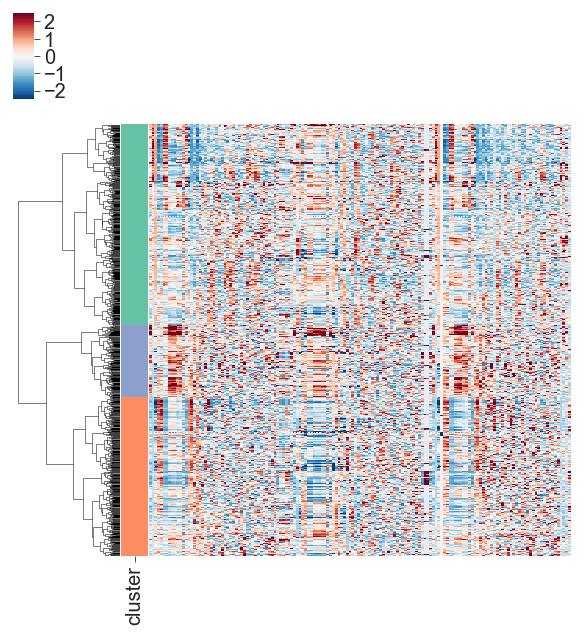

In [6]:
# cols = geom_cols
n_clusters = 3

func.hc(df, cols, n_clusters, save=True)

In [ ]:
func.hc(dfB, geom_cols, n_clusters=3, save=False)

In [ ]:
func.hc(dfC, geom_cols, n_clusters=3, save=False)

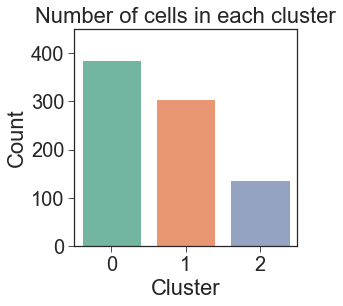

In [95]:
# Number of observations in each cluster
plt.rcParams['figure.figsize'] = (4, 4)
row_colors, palette = create_palette(df, by='cluster')

sns.countplot(x="cluster", data=df, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("Count");
plt.ylim([0, 450])
plt.title("Number of cells in each cluster");

In [ ]:
df.groupby('cluster').size()

In [ ]:
dfB.groupby('cluster').size()

In [ ]:
dfC.groupby('cluster').size()

## Distribution of clusters

### Simple proportion:
** Proportion of cells of each cluster to total cell number per stiffness**

In [ ]:
counts = df.groupby('stiffness').cluster.value_counts().unstack()
cluster_cols = ['cluster'+ str(n) for n in range(n_clusters)]
counts.columns = cluster_cols
counts['total'] = df.groupby('stiffness').size()
for col in cluster_cols:
    counts[col] = counts[col] / counts.total * 100
counts

In [ ]:
counts.iloc[:, 0 : n_clusters].plot(kind='bar', width=0.7, 
                                    stacked=True, 
                                    color=palette.values(), 
                                    figsize=(5, 5));

plt.xticks(rotation='horizontal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), 
           fontsize=18, 
           labels= ['Cell type ' + str(i) for i in range(n_clusters)]);
plt.xlabel("Stiffness");
plt.ylabel("Percentage");
plt.title("Proportion of cells of each type");
plt.savefig('../results/Clusters geom_cols.png', bbox_inches='tight', dpi=300);

### Add confidence intervals for proportions
** For two clusters only**

In [ ]:
if n_clusters > 2:
    print("Error, check maths!")
else:
    counts['err'] = 1.96 * np.sqrt(counts.cluster0 * counts.cluster1 / counts.total)

In [ ]:
counts.loc[:, ['cluster0', 'cluster1']].plot(kind='bar', width=0.8, 
                                             yerr=counts.err, capsize=4,
                                             color=palette.values(), 
                                             figsize=(6, 4));

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, 
           labels=['Cell type ' + str(i) for i in range(n_clusters)]);
plt.xticks(rotation='horizontal')
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
plt.ylim([0, 100])
# plt.title("Proportion of cells of each type across stiffness values");
plt.savefig('../results/Clusters geom_cols.png', bbox_inches='tight', dpi=300);

### Distribution of clusters across images and stiffness values

In [ ]:
counts = df.groupby(['stiffness', 'image']).cluster.value_counts().unstack().fillna(0)
counts.columns = ['cluster 1', 'cluster 2', 'cluster 3']
counts['total'] = df.groupby(['stiffness', 'image']).size()
counts['p1'] = counts['cluster 1'] / counts.total * 100
counts['p2'] = counts['cluster 2'] / counts.total * 100
counts['p3'] = counts['cluster 3'] / counts.total * 100
counts.head()

In [ ]:
counts.reset_index(inplace=True)
counts = pd.melt(counts, id_vars=['stiffness'], value_vars=['p1', 'p2', 'p3'])
counts.head()

In [ ]:
plt.rcParams['figure.figsize'] = (5, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.barplot(x='stiffness', y='value', 
            hue='variable', data=counts,
            ci=95, capsize=.1, 
            palette=palette.values());
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
plt.ylim([0, 80]);
# plt.title("Distribution of cell types across stiffness values");
plt.savefig('../results/Clusters geom_cols + error bars.png', bbox_inches='tight', dpi=300);

# An average "cell" of each cluster

In [ ]:
from sklearn.metrics import pairwise_distances


df_scaled = pd.concat([df.loc[:, ['label', 'stiffness', 'cluster']], 
                       pd.DataFrame(data = X_scaled, columns = cols)], axis=1)

_, pc_cols, pc_df = func.pca(df, cols)

row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (7, 7)

sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, hue='cluster', palette=palette);
plt.xlabel("PC1")
plt.ylabel("PC2")

for cluster in range(n_clusters):
    avg_cell_pca = pc_df.loc[pc_df.cluster == cluster, pc_cols].mean().values.reshape(1, -1)
    
    plt.scatter(avg_cell_pca[0,0], avg_cell_pca[0,1], s=200, marker='X', edgecolor='white', c='k');
    
    distances = pairwise_distances(pc_df.loc[pc_df.cluster == cluster, pc_cols],
                                   avg_cell_pca.ravel().reshape(1, -1))
    avg_cell = df.loc[df.cluster == cluster].reset_index().iloc[distances.argmin()]
    print("\nThe centroid of cluster {} is the cell with local index {} and label {}.".format(cluster, distances.argmin(), avg_cell.label))
    
    print("Cluster variance:", (distances**2).mean())
    
plt.legend(fontsize=18);
plt.savefig('../results/Clusters PCA.png', bbox_inches='tight', dpi=300);

# Determine most important features

** Hyperparameter tuning **

In [ ]:
best_rf_clf = rf.random_search_param(rf_clf, X_train, y_train)

** Save the best estimator **

In [ ]:
joblib.dump(best_rf_clf, 'models/try_new_approach.pkl')

** Load the best estimator **

In [ ]:
best_rf_clf = joblib.load('models/try_new_approach.pkl')

In [7]:
X = df[cols]
y = df.cluster

selected_features = 'measurements_5_over90_morph.txt'
X = proc.select_features(X, filename=selected_features, cols='geom')
 
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

### Save the current model
joblib.dump(rf_clf, 'models/latest_rf_clf.pkl')

Training set size: (743, 117)
Test set size: (83, 117)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

** Evaluate the model **

In [8]:
rf.test_rf_model(rf_clf, 0, X_train, X_test, y_train, y_test)


Number of observations of each class in the training set:
 0    340
1    279
2    124
Name: cluster, dtype: int64

Number of observations of each class in the test set:
 0    45
1    25
2    13
Name: cluster, dtype: int64

Null accuraccy: 0.5421686746987951
Testing accuraccy: 0.8554216867469879
Testing f-score: 0.8305665349143609
    1   0  2
1  22   3  0
0   4  40  1
2   4   0  9


Important features
                  feature    weight
2      eccentricity_cell  0.068224
1       compactness_cell  0.058965
5   majoraxislength_cell  0.050773
94      zernike_0_0_cyto  0.043993
7   minoraxislength_cell  0.038395
12      zernike_2_0_cell  0.035048
3            extent_cell  0.032798
0              area_cell  0.031497
9         perimeter_cell  0.029792
92     medianradius_cyto  0.026439
6      medianradius_cell  0.026186
10         solidity_cell  0.023825


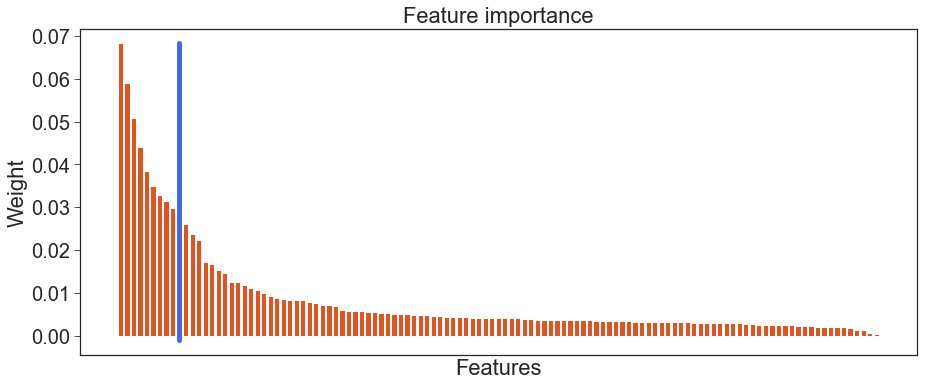

In [9]:
important_features = rf.get_important_features(rf_clf, X.columns)

** Make predictions for clumped cells**

In [100]:
X_ = clumped[cols]

selected_features = 'measurements_5_over90_morph.txt'
X_ = proc.select_features(X_, filename=selected_features, cols='geom')

clumped['cluster'] = rf_clf.predict(X_)

In [102]:
cluster_type = CategoricalDtype(categories=[0, 1, 2], ordered=True)
clumped.cluster = clumped.cluster.astype(cluster_type)

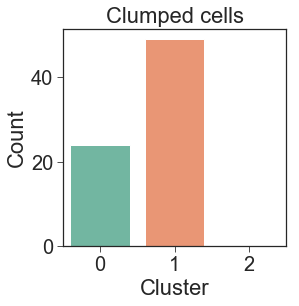

In [103]:
sns.countplot(clumped.cluster, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("Count");
plt.title("Clumped cells");

** Correlation between important features**

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)

sns.heatmap(df[bla].corr(), 
            annot=True,
            annot_kws={"size": 16},
            vmin=-1, vmax=1,
            xticklabels=False,
            yticklabels=False,
            cmap=sns.color_palette("RdBu_r", 20));
plt.savefig('../results/for thesis.png', bbox_inches='tight', dpi=300);

## Boxplots of most important features

In [10]:
def px_to_um(x):
    return x * 0.2076

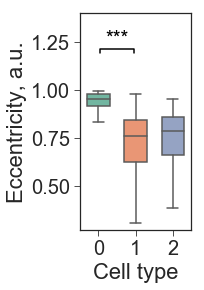

In [18]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')
col = important_features.iloc[0,0]

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0.27, 1.4], kind='boxplot')

plt.xlabel("Cell type");
plt.ylabel("Eccentricity, a.u.");
plt.savefig('../results/eccentricity per cluster.png', bbox_inches='tight', dpi=300);

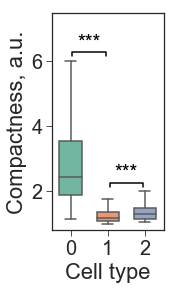

In [28]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')
col = important_features.iloc[1,0]

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0.8, 7.5], kind='boxplot')

plt.xlabel("Cell type");
plt.ylabel("Compactness, a.u.");
plt.savefig('../results/compactness per cluster.png', bbox_inches='tight', dpi=300);

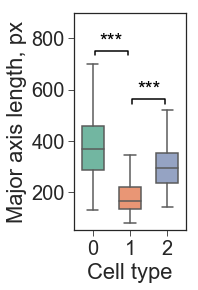

In [40]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')
col = important_features.iloc[2,0]

sns.boxplot(x=df.cluster, y=df[col],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [50, 900], kind='boxplot')

plt.xlabel("Cell type");
plt.ylabel("Major axis length, px");
plt.savefig('../results/majoraxislength per cluster.png', bbox_inches='tight', dpi=300);

## Cells that are further apart

In [ ]:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(X_scaled)

indices = np.unravel_index(np.argmax(dist, axis=None), dist.shape)

In [ ]:
plt.imshow(dist, zorder=2, cmap='Blues', interpolation='nearest');

In [ ]:
df.loc[indices[0], 'label'], df.loc[indices[1], 'label']

## PCA stiffness against cluster

In [ ]:
plt.rc("figure", figsize=(8, 8))

centroids = pc_df.groupby('stiffness')[['pc_1', 'pc_2']].mean().reset_index()

row_colors, palette = create_palette(df, by='stiffness')
sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
                style='cluster', markers=['o', 's'],
                hue='stiffness', palette=palette);

sns.scatterplot(x="pc_1", y="pc_2", data=centroids, 
                hue='stiffness', palette=palette, 
                s=200, marker='X', edgecolor='black', 
                legend=None);

# Relationship to biomarkers

## Correlations with biom features

integratedintensityedge_ecad      0.244577
maxintdisplacement_ker            0.205837
integratedintensityedge_vim       0.202363
entropy_vim_03                    0.183069
upperquartileintensity_vim        0.179010
entropy_vim_00                    0.178851
inversedifferencemoment_vim_03    0.176534
massdisplacement_ecad             0.176175
inversedifferencemoment_vim_00    0.174958
entropy_vim_01                    0.172280
dtype: float64


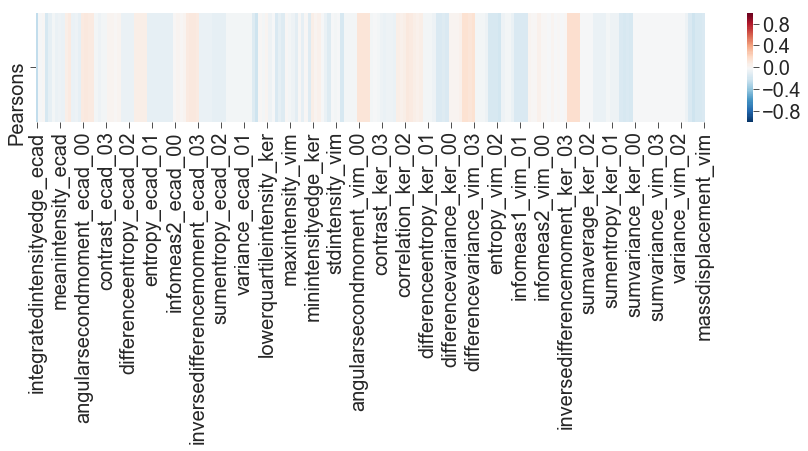

In [93]:
p_corr = df[biom_cols].corrwith(df.cluster, method='spearman')

print(p_corr.abs().sort_values(ascending=False).head(10))

plt.rcParams['figure.figsize'] = (15, 2)

sns.heatmap(pd.DataFrame(p_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

## Expression in clusters

**E-cadherin**

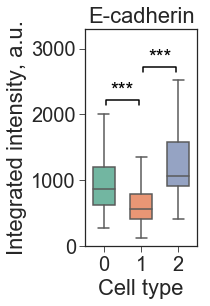

In [51]:
row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 4)

col = 'integratedintensity_ecad'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 3300], kind='boxplot')

plt.title("E-cadherin")
plt.xlabel("Cell type");
plt.ylabel("Integrated intensity, a.u.");
plt.savefig('../results/Ecad II per cluster.png', bbox_inches='tight', dpi=300);

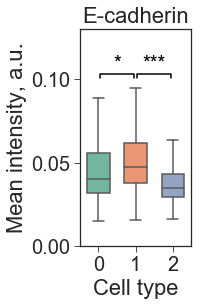

In [53]:
row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 4)

col = 'meanintensity_ecad'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 0.13], kind='boxplot')

plt.title("E-cadherin")
plt.xlabel("Cell type");
plt.ylabel("Mean intensity, a.u.");
plt.savefig('../results/Ecad MI per cluster.png', bbox_inches='tight', dpi=300);

** Vimentin**

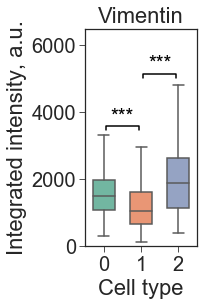

In [64]:
row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 4)

col = 'integratedintensity_vim'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 6500], kind='boxplot')

plt.title("Vimentin")
plt.xlabel("Cell type");
plt.ylabel("Integrated intensity, a.u.");
plt.savefig('../results/Vim II per cluster.png', bbox_inches='tight', dpi=300);

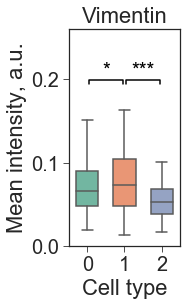

In [81]:
row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 4)

col = 'meanintensity_vim'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 0.26], kind='boxplot')

plt.title("Vimentin")
plt.xlabel("Cell type");
plt.ylabel("Mean intensity, a.u.");
plt.savefig('../results/Vim MI per cluster.png', bbox_inches='tight', dpi=300);

** Cytokeratins**

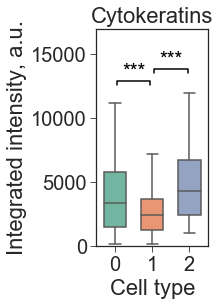

In [63]:
row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 4)

col = 'integratedintensity_ker'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 17000], kind='boxplot')

plt.title("Cytokeratins")
plt.xlabel("Cell type");
plt.ylabel("Integrated intensity, a.u.");
plt.savefig('../results/Ker II per cluster.png', bbox_inches='tight', dpi=300);

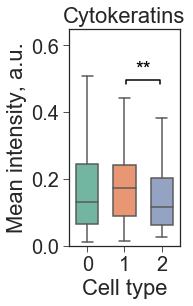

In [89]:
row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 4)

col = 'meanintensity_ker'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 0.65], kind='boxplot')

plt.title("Cytokeratins")
plt.xlabel("Cell type");
plt.ylabel("Mean intensity, a.u.");
plt.savefig('../results/Ker MI per cluster.png', bbox_inches='tight', dpi=300);

** CVR**

In [66]:
df = proc.cv_ratio(df, col1='integratedintensity_ker', col2='integratedintensity_vim')

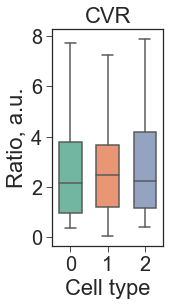

In [73]:
row_colors, palette = create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 4)

col = 'cvratio'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 10], kind='boxplot')

plt.title("CVR")
plt.xlabel("Cell type");
plt.ylabel("Ratio, a.u.");
plt.savefig('../results/CVR per cluster.png', bbox_inches='tight', dpi=300);

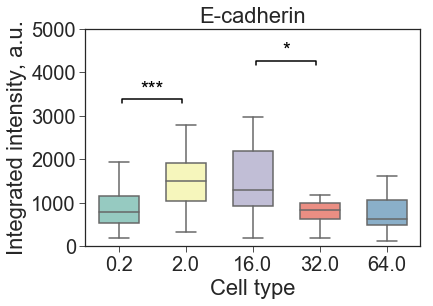

In [110]:
row_colors, palette = create_palette(df, by='stiffness')
plt.rcParams['figure.figsize'] = (6, 4)

col = 'integratedintensity_vim'

sns.boxplot(x='stiffness', y=col, data=df[df.cluster == 1],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df[df.cluster == 1], 'stiffness', col, equal_var=False, verbose=False)
func.stat_annot(df[df.cluster == 1], 'stiffness', col, x_start, x_end, signif, [0, 5000], kind='boxplot')

plt.title("E-cadherin")
plt.xlabel("Cell type");
plt.ylabel("Integrated intensity, a.u.");
# plt.savefig('../results/Ecad II per cluster.png', bbox_inches='tight', dpi=300);

### Mass displacement

** Show on a single plot**

In [ ]:
tmp = pd.melt(df[['stiffness', 'cluster', 'massdisplacement_ker', 'massdisplacement_ecad']],
              id_vars=['stiffness', 'cluster'],
              value_vars=['massdisplacement_ker', 'massdisplacement_ecad'], 
              var_name='biom', value_name='massdisp')

In [ ]:
plt.rcParams['figure.figsize'] = (5, 4)

row_colors, palette = create_palette(tmp, 'biom')

sns.boxplot(x=tmp.cluster, y=px_to_um(tmp.massdisp), 
            hue=tmp.biom, palette=palette,
            width=0.6, showfliers=False);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
plt.ylim([0, 17]);
plt.xlabel("Cell type");
plt.ylabel("Displacement, um");
plt.title("")
plt.savefig('../results/massdisp per cluster.png', bbox_inches='tight', dpi=300);

** Separate plots and statistical testing**

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.meanintensity_wga / df.area_cell, 
            width=0.6, palette=palette, showfliers=False);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("Mass displacement, um");
plt.title("Cytokeratins")
# plt.savefig('../results/massdisp ker per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('massdisplacement_ker')

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)
sns.boxplot(x=df.cluster, y=px_to_um(df.massdisplacement_vim), 
            width=0.6, palette=palette, showfliers=False);

plt.ylim([0, 17]);
plt.xlabel("Cell type");
plt.ylabel("Mass displacement, um");
plt.title("Vimentin");
plt.savefig('../results/massdisp vim per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('massdisplacement_vim')

## CTCF of ker and vim

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.ctcf_ker, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.ctcf_ker, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("CTCF, um");
plt.title("Cytokeratins");
plt.savefig('../results/ker per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('ctcf_ker')

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.ctcf_vim, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.ctcf_vim, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("CTCF, um");
plt.title("Vimentin");
plt.savefig('../results/vim per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('ctcf_vim')

## CV ratio

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.cvratio, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.cvratio, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("Ratio, a.u.");
plt.title("Cytokeratins to Vimentin ratio");
plt.savefig('../results/CVR per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('cvratio')

## Regions of biomarker levels

In [ ]:
df['region'] = "00"
df.loc[(df.ctcf_ker < df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "01"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim < df.ctcf_vim.median()), 'region'] = "10"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "11"

In [ ]:
# Number of observations in each region
sns.countplot(x="region", data=df);
plt.xlabel("Region");
plt.ylabel("Count");
plt.title("Number of cells in each region");

In [ ]:
plt.rcParams['figure.figsize'] = (12, 12)

sns.scatterplot(x='ctcf_ker', y='ctcf_vim', data=df,
                hue='stiffness', style='region', s=100,
                palette=sns.color_palette("Set3", 5));

In [ ]:
df.groupby(['stiffness', 'region']).size()

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)

tmp = df.groupby(['stiffness', 'region']).size().unstack()

tmp['total'] = df.groupby('stiffness').size()

tmp['00'] = tmp['00'] / tmp.total * 100
tmp['01'] = tmp['01'] / tmp.total * 100
tmp['10'] = tmp['10'] / tmp.total * 100
tmp['11'] = tmp['11'] / tmp.total * 100

tmp.iloc[:, 0 : 4].plot(kind='bar', width=0.7, stacked=True, color=sns.color_palette("Set2", 4));


plt.xticks(rotation='horizontal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, 
           labels=('Low cytokeratins, low vimentin', 
                   'Low cytokeratins, high vimentin', 
                   'High cytokeratins, low vimentin', 
                   'High cytokeratins, high vimentin'));
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
# plt.title("Proportion of cells of each type across stiffness values");

In [ ]:
df.groupby(['stiffness', 'cluster']).ctcf_ker.mean()

In [ ]:
df.groupby(['stiffness', 'cluster']).ctcf_vim.median()

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.barplot(x='stiffness', y='ctcf_ker', 
            hue='cluster', data=df,
            ci='sd', capsize=.1,
#             showfliers=False,
            palette=palette.values());

In [ ]:
sns.barplot(x='stiffness', y='ctcf_vim', 
            hue='cluster', data=df,
            ci=95, capsize=.1,
#             showfliers=False,
            palette=palette.values());

In [ ]:
sns.boxplot(x=df.stiffness, y=df.massdisplacement_vim, width = 0.6, showfliers=False);